<a href="https://colab.research.google.com/github/marcinwolter/NORCC-SUMMER_2022/blob/main/simple_mnist_mdn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple MNIST dense net with Mixture Density Network

Using on:
https://keras.io/examples/vision/mnist_convnet/ 

## Setup

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt


## Prepare the data

In [ ]:

def prepare_data(x_train, y_train, x_test, y_test,num_classes):
  #Select 2 classes
  N_CLASSES = num_classes

  indices = np.where(y_train < N_CLASSES) # if few classes needed
  indices = indices[0]
  np.random.shuffle(indices)
  x_train = x_train[indices]
  y_train = y_train[indices]

  indices = np.where(y_test < N_CLASSES) # if few  classes only
  indices = indices[0]
  np.random.shuffle(indices)
  x_test = x_test[indices]
  y_test = y_test[indices]

  # Scale images to the [0, 1] range
  x_train = x_train.astype("float32") / 255
  x_test = x_test.astype("float32") / 255
  # Make sure images have shape (28, 28, 1)
  x_train = np.expand_dims(x_train, -1)
  x_test = np.expand_dims(x_test, -1)
  print("x_train shape:", x_train.shape)
  print(x_train.shape[0], "train samples")
  print(x_test.shape[0], "test samples")


  # convert class vectors to binary class matrices
  y_train = keras.utils.to_categorical(y_train, num_classes)
  y_test = keras.utils.to_categorical(y_test, num_classes)
  
  return x_train, y_train, x_test, y_test

In [ ]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train, y_train, x_test, y_test = prepare_data(x_train, y_train, x_test, y_test,num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


# **Install keras-mdn-layer**

In [ ]:
! pip install keras-mdn-layer
import mdn

  Created wheel for keras-mdn-layer: filename=keras_mdn_layer-0.3.0-cp36-none-any.whl size=7056 sha256=88ae7221326b3a822c4eb9cbf9e57f2cd39b8b48d3ae748f5226966c1aaaee65
  Stored in directory: /root/.cache/pip/wheels/b6/e3/ba/8fb07898b8c8e5d4c1a035add0b71629b2fbe82ee8a5f0a2c8
Successfully built keras-mdn-layer


Parameters for MDN

In [ ]:
N_HIDDEN = 256  # number of hidden units in the Dense layer
N_MIXES = 1  # number of mixture components
OUTPUT_DIMS = num_classes  # number of real-values predicted by each mixture component


## Build the model

In [ ]:
model = keras.Sequential()
model.add(keras.Input(shape=input_shape))
model.add(layers.Flatten())
model.add(layers.Dense(N_HIDDEN, activation="relu"))
model.add(layers.Dense(N_HIDDEN, activation="relu"))
model.add(layers.Dense(N_HIDDEN, activation="relu"))

model.add(mdn.MDN(OUTPUT_DIMS, N_MIXES))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
mdn (MDN)                    (None, 21)                5397      
Total params: 337,941
Trainable params: 337,941
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [ ]:
batch_size = 128
epochs = 20

# This was for normal dense network
#model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.compile(loss=mdn.get_mixture_loss_func(OUTPUT_DIMS,N_MIXES), optimizer=keras.optimizers.Adam())


model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs) #  validation_data=(x_test, y_test)) #validation_split=0.1)

Epoch 1/20
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
469/469 [==============================] - 5s 3ms/step - loss: -6.6758
Epoch 2/20
469/469 [==============================] - 2s 4ms/step - loss: -15.4207
Epoch 3/20
469/469 [==============================] - 2s 4ms/step - loss: -19.6857
Epoch 4/20
469/469 [==============================] - 2s 3ms/step - loss: -20.1215
Epoch 5/20
469/469 [==============================] - 2s 4ms/step - loss: -20.0232
Epoch 6/20
469/469 [==============================] - 2s 4ms/step - loss: -24.0298
Epoch 7/20
469/469 [==============================] - 2s 4ms/step - loss: -25.3949
Epoch 8/20
469/469 [==============================] - 2s 3ms/step - loss: -26.9950
Epoch 9/20
469/469 [==============================] - 2s 4ms/step - loss: -25.1415
Epoch 10/20
469/469 [==============================] - 2s 4ms/step - loss: -28.2660
Epoch 11/20
469/469 [==============================] - 2s 4ms/step - loss: -24.6455

# **Model prediction with MDN**

In [ ]:
y_test_out = model.predict(x_test)

# y_samples - output from MDN, contains all information
y_samples = np.apply_along_axis(mdn.sample_from_output, 1, y_test_out, OUTPUT_DIMS, N_MIXES, temp=1.0)


print(x_test.shape)
print(y_test_out.shape)
print(y_samples.shape)


(10000, 28, 28, 1)
(10000, 21)
(10000, 1, 10)


In [ ]:

# Split up the mixture parameters (for future fun)
# means of Gaussians
mus = y_test_out[:,:N_MIXES*OUTPUT_DIMS]
# sigmas of Gaussians
sigs = y_test_out[:,N_MIXES*OUTPUT_DIMS:2*N_MIXES*OUTPUT_DIMS]
#pis = mdn.softmax(y_test_out[:,-N_MIXES:], t=1.0)


In [ ]:
#print(y_samples)

#print(y_test_out)
#print(y_test[1:7])

#print(mus)
#print(sigs)


0.0904177


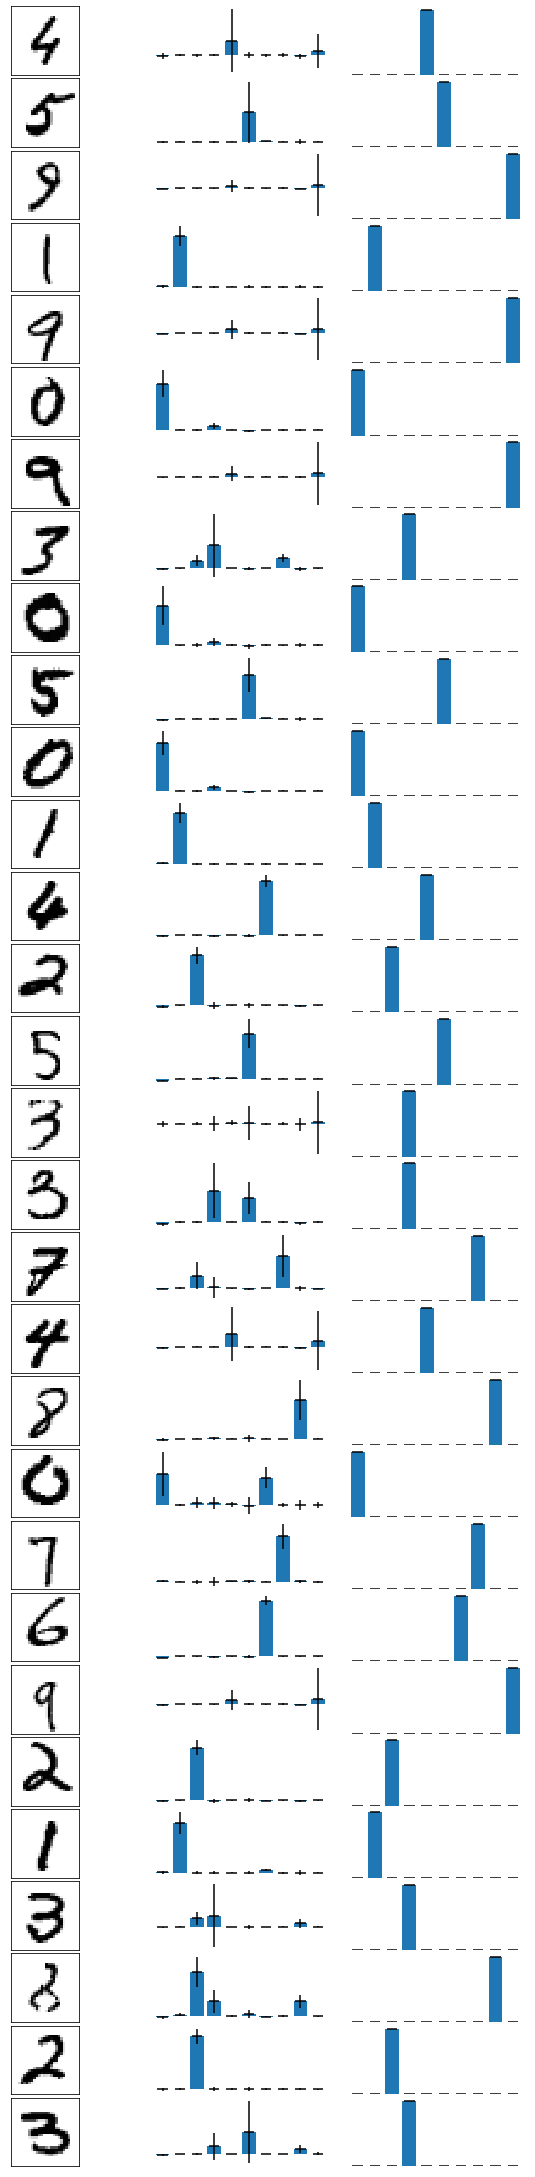

In [ ]:
# use the model to predict the labels of the test data



# Plot the prediction
fig = plt.figure(figsize=(8, 30))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)


# plot the digits: each image is 28x28 pixels
n_img=30
for i in range(n_img):
    ax = fig.add_subplot(n_img, 3, 3*i + 1, xticks=[], yticks=[])
    ax.imshow(x_test[i].reshape(28,28), cmap=plt.cm.binary, interpolation='nearest')

    ax = fig.add_subplot(n_img, 3, 3*i + 2, xticks=[0,1,2,3,4,5,6,7,8,9], yticks=[])
    xbar = np.linspace(1, OUTPUT_DIMS, num=OUTPUT_DIMS)
    ax.bar(xbar,mus[i],yerr=sigs[i],xerr=0.3,)
    ax.axis('off')

    ax = fig.add_subplot(n_img, 3, 3*i + 3, xticks=[0,1,2,3,4,5,6,7,8,9], yticks=[])
    xbar = np.linspace(1, OUTPUT_DIMS, num=OUTPUT_DIMS)
    ax.bar(xbar,y_test[i],yerr=0.0,xerr=0.3)
    ax.axis('off')

    #print(mus[i])
    #print(sigs[i])
    #print(pis[i])

print("Average error on probability = ",np.mean(sigs))    

# **Load fashion MNIST**

In [ ]:
# Model / data parameters
num_classes_f = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(xf_train, yf_train), (xf_test, yf_test) = keras.datasets.fashion_mnist.load_data()

xf_train, yf_train, xf_test, yf_test = prepare_data(xf_train, yf_train, xf_test, yf_test, num_classes)

4423680/4422102 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


# **Test fashion MNIST using the network trained on digits**

In [ ]:
yf_test_out = model.predict(xf_test)

# y_samples - output from MDN, contains all information
yf_samples = np.apply_along_axis(mdn.sample_from_output, 1, yf_test_out, OUTPUT_DIMS, N_MIXES, temp=1.0)


In [ ]:

# Split up the mixture parameters (for future fun)
# means of Gaussians
musf = yf_test_out[:,:N_MIXES*OUTPUT_DIMS]
# sigmas of Gaussians
sigsf = yf_test_out[:,N_MIXES*OUTPUT_DIMS:2*N_MIXES*OUTPUT_DIMS]
#pis = mdn.softmax(y_test_out[:,-N_MIXES:], t=1.0)


Average error on probability =  0.18832716


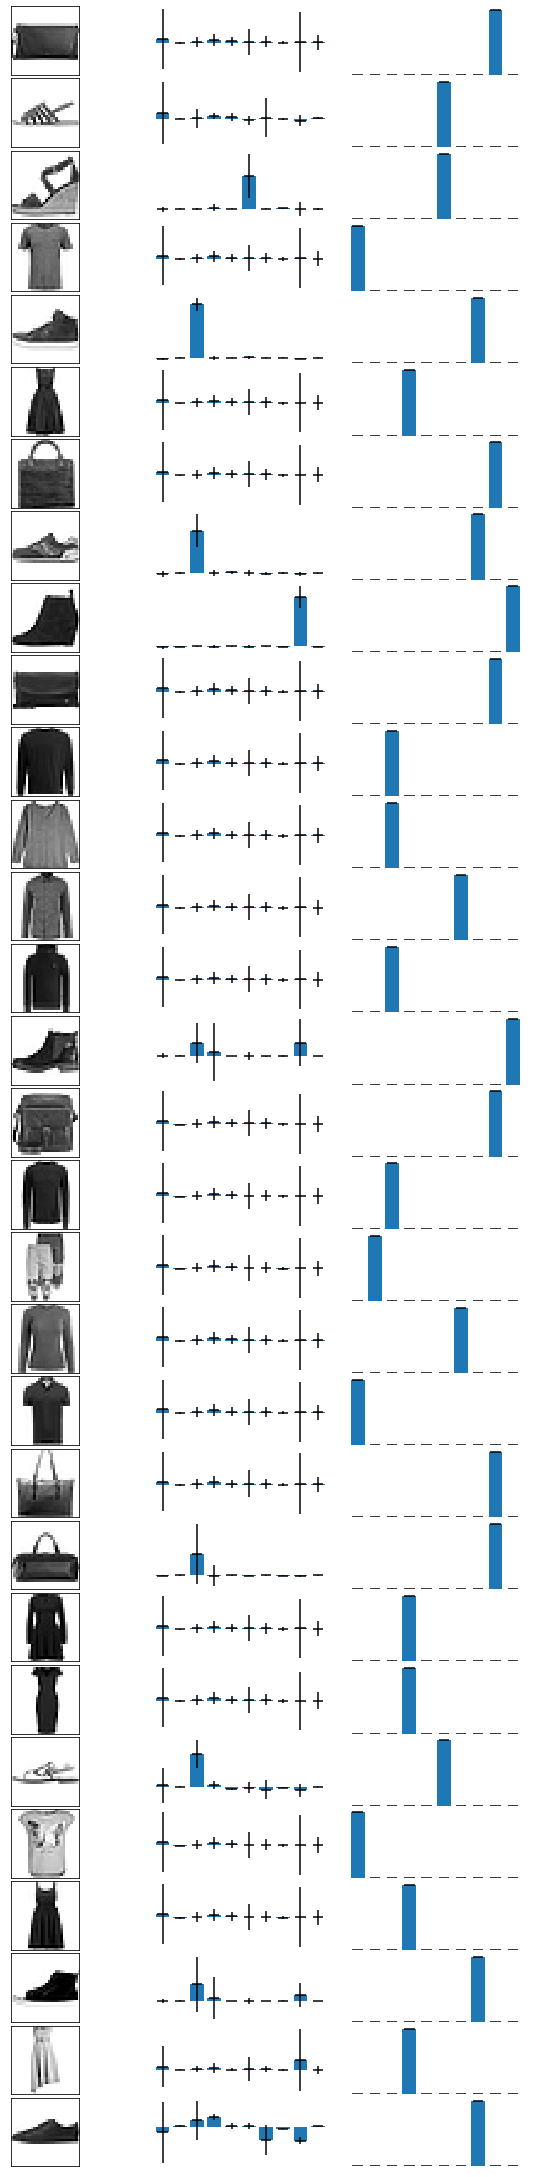

In [ ]:
# use the model to predict the labels of the test data



# Plot the prediction
fig = plt.figure(figsize=(8, 30))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)


# plot the digits: each image is 28x28 pixels
n_img=30
for i in range(n_img):
    ax = fig.add_subplot(n_img, 3, 3*i + 1, xticks=[], yticks=[])
    ax.imshow(xf_test[i].reshape(28,28), cmap=plt.cm.binary, interpolation='nearest')

    ax = fig.add_subplot(n_img, 3, 3*i + 2, xticks=[0,1,2,3,4,5,6,7,8,9], yticks=[])
    xbar = np.linspace(1, OUTPUT_DIMS, num=OUTPUT_DIMS)
    ax.bar(xbar,musf[i],yerr=sigsf[i],xerr=0.3,)  #,yerr=sigsf[i]
    ax.axis('off')

    ax = fig.add_subplot(n_img, 3, 3*i + 3, xticks=[0,1,2,3,4,5,6,7,8,9], yticks=[])
    xbar = np.linspace(1, OUTPUT_DIMS, num=OUTPUT_DIMS)
    ax.bar(xbar,yf_test[i],yerr=0.0,xerr=0.3)
    ax.axis('off')

    #print(mus[i])
    #print(sigs[i])
    #print(pis[i])

print("Average error on probability = ",np.mean(sigsf))    